In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
import joblib
import os

In [36]:
# 1. Load Data
DATA_PATH = "../../Data/Processed/"
if not os.path.exists(DATA_PATH + "X_train.csv"):
    print(f"Cannot find the files")
    DATA_PATH = ""

print("Loading data...")
X_train = pd.read_csv(f"{DATA_PATH}X_train.csv")
y_train = pd.read_csv(f"{DATA_PATH}y_train.csv").values.flatten()
X_test = pd.read_csv(f"{DATA_PATH}X_test.csv")
y_test = pd.read_csv(f"{DATA_PATH}y_test.csv").values.flatten()

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Loading data...
Train shape: (5285, 20)
Test shape: (1322, 20)


In [37]:
# 2. Build Random Forest model
print("\nTraining Random Forest Model...")
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],        
    'min_samples_leaf': [1, 2, 4],          # To prevent overfitting
    'max_features': ['sqrt', 'log2', None]  
}

# 3. Base model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# 4. Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=20,
    cv=3,
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# 5. Train and find the best model

# Give higher weight to samples with score > 80 to force model to learn them
#sample_weights = np.ones(len(y_train))
#high_score_indices = y_train > 80
#sample_weights[high_score_indices] = 10

pt = PowerTransformer(method='box-cox')

# Fit and transform y_train
# Reshape is needed because fit_transform expects a 2D array
y_train_transformed = pt.fit_transform(y_train.reshape(-1, 1)).ravel()

rf_random.fit(X_train, y_train_transformed)
print(f"Best parameter: {rf_random.best_params_}")
model = rf_random.best_estimator_


Training Random Forest Model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameter: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}


In [38]:
# 6. Store the model
joblib.dump(model, "rf_model.joblib")
joblib.dump(pt, "power_transformer.joblib")
print("\nModel saved as rf_model.joblib")
print("\nTransformer saved as power_transformer.joblib")
    
# Get predictions (in the transformed scale)
preds_transformed = model.predict(X_test)
# Inverse Transform to get actual scores
# We need to reshape for inverse_transform, then ravel back to 1D array
preds = pt.inverse_transform(preds_transformed.reshape(-1, 1)).ravel()

# 7. Evaluation
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mse)

print("\n======================")
print("RF TEST RESULTS")
print("======================")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)


Model saved as rf_model.joblib

Transformer saved as power_transformer.joblib

RF TEST RESULTS
MSE : 4.238523043134658
RMSE: 2.0587673601295164
MAE : 0.9970103782924846


In [39]:
# 8. Prediction Examples
int_preds = np.rint(preds).astype(int)
print("\nSample predictions (integerized):")
for i in range(10):
    print(f"Predicted: {int_preds[i]} | Actual: {y_test[i]}")

# 9. Accuracy Analysis (to make a comparison with teammate's NN model）
thresholds = [0.01, 0.02, 0.03, 0.05, 0.10]
y_test_safe = np.where(y_test == 0, 1e-9, y_test)

print("\nAccuracy at different tolerance percentages:")
for t in thresholds:
    diff_percent = np.abs(int_preds - y_test_safe) / y_test_safe
    correct = np.sum(diff_percent <= t)
    total = len(y_test)
    acc = correct / total * 100
    print(f"±{int(t*100)}% accuracy: {correct}/{total}  ({acc:.2f}%)")




Sample predictions (integerized):
Predicted: 65 | Actual: 65
Predicted: 66 | Actual: 65
Predicted: 70 | Actual: 71
Predicted: 66 | Actual: 64
Predicted: 65 | Actual: 66
Predicted: 66 | Actual: 66
Predicted: 70 | Actual: 72
Predicted: 67 | Actual: 66
Predicted: 70 | Actual: 70
Predicted: 70 | Actual: 70

Accuracy at different tolerance percentages:
±1% accuracy: 489/1322  (36.99%)
±2% accuracy: 1085/1322  (82.07%)
±3% accuracy: 1186/1322  (89.71%)
±5% accuracy: 1305/1322  (98.71%)
±10% accuracy: 1315/1322  (99.47%)


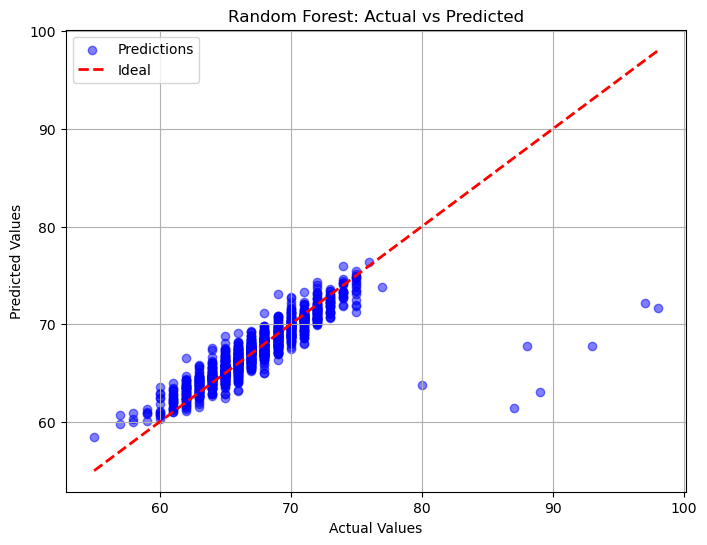

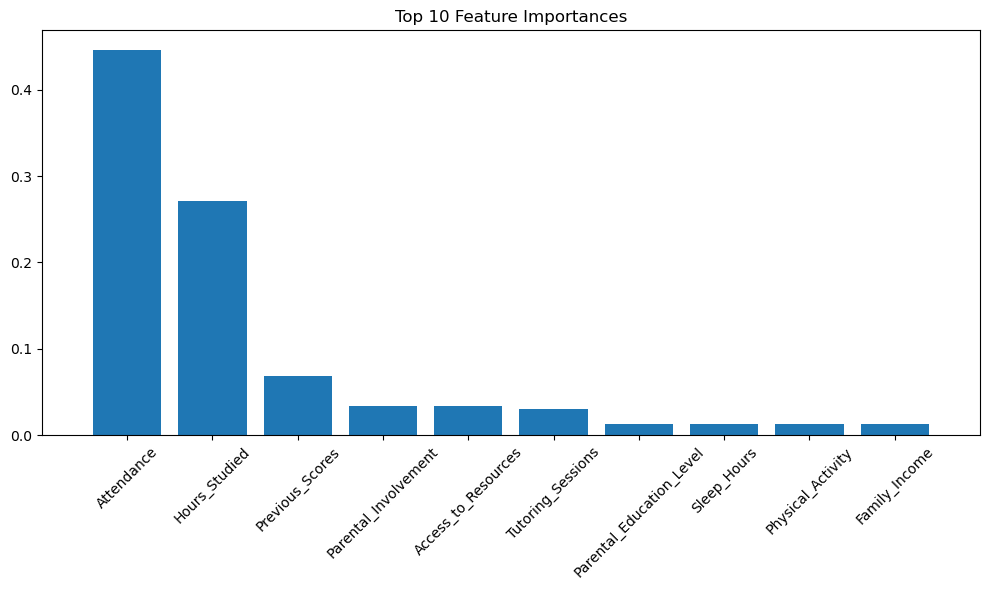

[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=30, max_features=N

In [40]:
# 10. Graph
# Random Forest: actual v.s. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Top 10
    top_k = 10
    plt.figure(figsize=(10, 6))
    plt.title("Top 10 Feature Importances")
    plt.bar(range(top_k), importances[indices[:top_k]], align="center")
    plt.xticks(range(top_k), [X_train.columns[i] for i in indices[:top_k]], rotation=45)
    plt.xlim([-1, top_k])
    plt.tight_layout()
    plt.show()